# Recommendation Algorithms

**Target:** Generate 20 recommendations per user for submission

## MODEL 1: POPULARITY BASELINE

1.Install & Import Libraries

In [3]:
import numpy as np
import pandas as pd
from collections import Counter
from tqdm import tqdm
import time

np.random.seed(42)

print("Libraries imported")

Libraries imported


#2.Load Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/RS_PROJECT/'

def load_data(filepath):
    data = {}
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 2:
                data[int(parts[0])] = [int(x) for x in parts[1:]]
    return data

train_data = load_data(BASE_PATH + 'train_split.txt')
val_data = load_data(BASE_PATH + 'val_split.txt')
test_data = load_data(BASE_PATH + 'test_split.txt')

print(f"Train: {len(train_data):,} users")
print(f"Val: {len(val_data):,} users")
print(f"Test: {len(test_data):,} users")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train: 51,420 users
Val: 51,418 users
Test: 51,411 users


#3. Build Popularity Model

In [5]:
class PopularityModel:
    def __init__(self):
        self.popular_items = None

    def fit(self, train_data):
        all_items = [item for items in train_data.values() for item in items]
        item_counts = Counter(all_items)
        self.popular_items = [item for item, _ in item_counts.most_common()]
        print(f"Model trained on {len(item_counts):,} unique items")

    def recommend(self, user_id, train_data, n=20):
        seen_items = set(train_data.get(user_id, []))
        recommendations = [item for item in self.popular_items if item not in seen_items]
        return recommendations[:n]

model = PopularityModel()
model.fit(train_data)

Model trained on 91,522 unique items


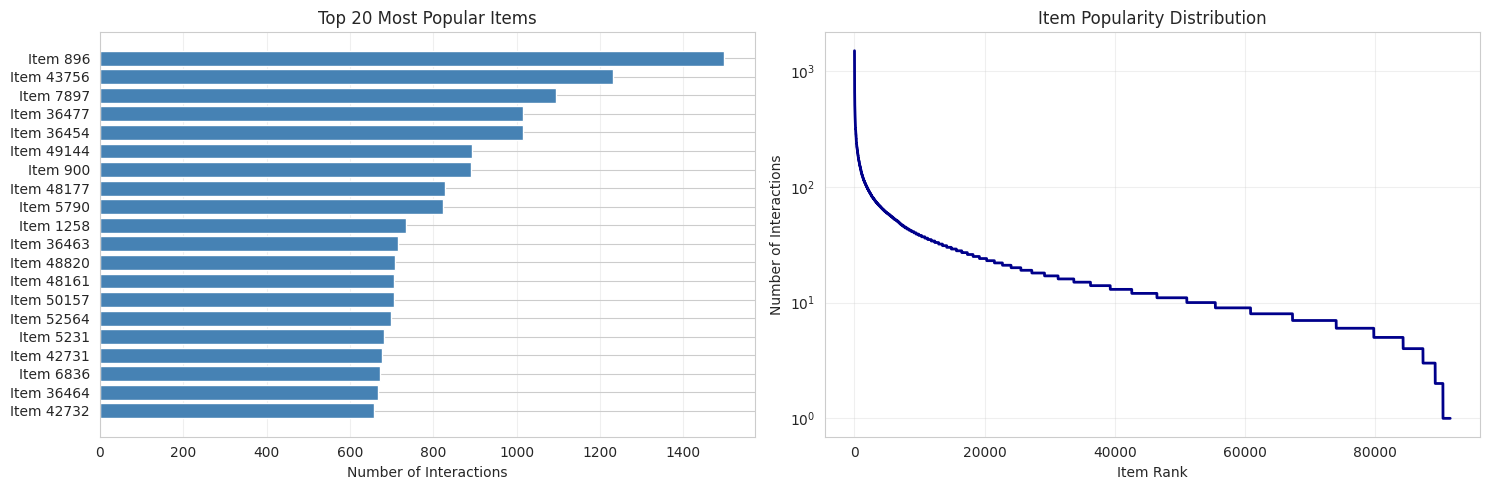


Popularity Statistics:
  Min interactions per item: 1
  Max interactions per item: 1,497
  Mean interactions per item: 20.30


In [11]:
# Create item popularity Counter for visualization
all_items = [item for items in train_data.values() for item in items]
item_popularity = Counter(all_items)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

top_20 = item_popularity.most_common(20)
items_20 = [f"Item {x[0]}" for x in top_20]
counts_20 = [x[1] for x in top_20]

axes[0].barh(items_20, counts_20, color='steelblue')
axes[0].set_xlabel('Number of Interactions')
axes[0].set_title('Top 20 Most Popular Items')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3, axis='x')

popularity_counts = sorted(item_popularity.values(), reverse=True)
axes[1].plot(popularity_counts, color='darkblue', linewidth=2)
axes[1].set_xlabel('Item Rank')
axes[1].set_ylabel('Number of Interactions')
axes[1].set_title('Item Popularity Distribution')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPopularity Statistics:")
print(f"  Min interactions per item: {min(item_popularity.values())}")
print(f"  Max interactions per item: {max(item_popularity.values()):,}")
print(f"  Mean interactions per item: {np.mean(list(item_popularity.values())):.2f}")

#4. Evaluation Functions

In [6]:
def ndcg_at_k(predictions, ground_truth, k=20):
    gt_set = set(ground_truth)
    dcg = sum(1.0 / np.log2(i + 2) for i, item in enumerate(predictions[:k]) if item in gt_set)
    idcg = sum(1.0 / np.log2(i + 2) for i in range(min(len(ground_truth), k)))
    return dcg / idcg if idcg > 0 else 0.0

def precision_at_k(predictions, ground_truth, k=20):
    gt_set = set(ground_truth)
    return sum(1 for item in predictions[:k] if item in gt_set) / k

def recall_at_k(predictions, ground_truth, k=20):
    if not ground_truth:
        return 0.0
    gt_set = set(ground_truth)
    return sum(1 for item in predictions[:k] if item in gt_set) / len(ground_truth)

def hit_rate_at_k(predictions, ground_truth, k=20):
    gt_set = set(ground_truth)
    return 1.0 if any(item in gt_set for item in predictions[:k]) else 0.0

print("Evaluation functions ready")

Evaluation functions ready


#5. Evaluate Model

In [7]:
def evaluate(model, train_data, test_data, k=20):
    ndcg_scores = []
    precision_scores = []
    recall_scores = []
    hit_rate_scores = []

    for user_id, ground_truth in tqdm(test_data.items(), desc="Evaluating"):
        predictions = model.recommend(user_id, train_data, n=k)
        ndcg_scores.append(ndcg_at_k(predictions, ground_truth, k))
        precision_scores.append(precision_at_k(predictions, ground_truth, k))
        recall_scores.append(recall_at_k(predictions, ground_truth, k))
        hit_rate_scores.append(hit_rate_at_k(predictions, ground_truth, k))

    return {
        'NDCG@20': np.mean(ndcg_scores),
        'Precision@20': np.mean(precision_scores),
        'Recall@20': np.mean(recall_scores),
        'Hit_Rate@20': np.mean(hit_rate_scores)
    }

print("Validation Results:")
val_results = evaluate(model, train_data, val_data, k=20)
for metric, value in val_results.items():
    print(f"  {metric}: {value:.4f}")

print("\nTest Results:")
test_results = evaluate(model, train_data, test_data, k=20)
for metric, value in test_results.items():
    print(f"  {metric}: {value:.4f}")

Validation Results:


Evaluating: 100%|██████████| 51418/51418 [12:44<00:00, 67.23it/s]


  NDCG@20: 0.0031
  Precision@20: 0.0004
  Recall@20: 0.0080
  Hit_Rate@20: 0.0080

Test Results:


Evaluating: 100%|██████████| 51411/51411 [12:05<00:00, 70.84it/s]

  NDCG@20: 0.0036
  Precision@20: 0.0005
  Recall@20: 0.0092
  Hit_Rate@20: 0.0092


#6. Generate Submission

In [8]:
def generate_submission(model, train_data, val_data, test_data, output_file):
    all_users = sorted(set(train_data) | set(val_data) | set(test_data))

    print(f"Generating predictions for {len(all_users):,} users...")
    with open(output_file, 'w') as f:
        for user_id in tqdm(all_users, desc="Writing"):
            recommendations = model.recommend(user_id, train_data, n=20)
            f.write(f"{user_id} " + " ".join(map(str, recommendations)) + "\n")

    print(f"Saved to: {output_file}")
    return output_file, all_users

submission_file, all_users = generate_submission(
    model, train_data, val_data, test_data,
    BASE_PATH + 'model1_popularity_predictions.txt'
)

Generating predictions for 51,420 users...


Writing: 100%|██████████| 51420/51420 [12:05<00:00, 70.88it/s]

Saved to: /content/drive/MyDrive/RS_PROJECT/model1_popularity_predictions.txt


# 7. Validate Submission

In [9]:
def validate_submission(filepath, expected_users, k=20):
    print("\nValidating submission...")
    issues = 0

    with open(filepath, 'r') as f:
        lines = f.readlines()

    if len(lines) != len(expected_users):
        print(f"  Line count mismatch: expected {len(expected_users)}, got {len(lines)}")
        issues += 1

    for i in range(min(5, len(lines))):
        parts = lines[i].strip().split()
        if len(parts) != k + 1:
            print(f"  Line {i+1}: expected {k+1} values, got {len(parts)}")
            issues += 1
        if len(parts[1:]) != len(set(parts[1:])):
            print(f"  Line {i+1}: contains duplicates")
            issues += 1

    with open(filepath, 'r') as f:
        file_users = {int(line.split()[0]) for line in f}

    missing = set(expected_users) - file_users
    if missing:
        print(f"  Missing {len(missing)} users")
        issues += 1

    print(f"  Result: {'PASS' if issues == 0 else 'FAIL'}")
    return issues == 0

validate_submission(submission_file, all_users, k=20)


Validating submission...
  Result: PASS


True

#8. Save Results

In [10]:
results_df = pd.DataFrame([{
    'Model': 'Popularity Baseline',
    'NDCG@20_Val': val_results['NDCG@20'],
    'Precision@20_Val': val_results['Precision@20'],
    'Recall@20_Val': val_results['Recall@20'],
    'Hit_Rate@20_Val': val_results['Hit_Rate@20'],
    'NDCG@20_Test': test_results['NDCG@20'],
    'Precision@20_Test': test_results['Precision@20'],
    'Recall@20_Test': test_results['Recall@20'],
    'Hit_Rate@20_Test': test_results['Hit_Rate@20']
}])

results_df.to_csv(BASE_PATH + 'model1_results.csv', index=False)
print("\nModel 1 Complete")
print(results_df.to_string(index=False))


Model 1 Complete
              Model  NDCG@20_Val  Precision@20_Val  Recall@20_Val  Hit_Rate@20_Val  NDCG@20_Test  Precision@20_Test  Recall@20_Test  Hit_Rate@20_Test
Popularity Baseline      0.00311          0.000398       0.007954         0.007954      0.003593           0.000459        0.009181          0.009181
